<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# Linear diffusion exercise with Landlab

This notebook is adapted from *Landscape Evolution Modeling with CHILD* by Gregory Tucker and Stephen Lancaster. This notebook was created by Nicole Gasparini at Tulane University.

<hr>
For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a>
<hr>


**What is this notebook?**

This notebook illustrates the evolution of landforms dominated by processes that result in linear diffusion of sediment. In other words, the downhill flow of soil is proportional to the (downhill) gradient of the land surface multiplied by a transport coefficient.

The notebook first illustrates a simple example of a diffusing hillslope. We then provide a number of exercises for students to do on their own. This set of exercises is recomended for students in a quantitative geomorphology class, who have been introduced to the linear diffusion equation in class. 

**Application of linear diffusion transport law:**

For relatively gentle, soil-mantled slopes, there is reasonably strong support for a transport law of the form:
\begin{equation}
q_s = -D \nabla z
\end{equation}
where ${q}_s$ is the transport rate with dimensions of L$^2$T$^{-1}$;  $D$ is a transport coefficient with dimensions of L$^2$T$^{-1}$; and $z$ is elevation. $\nabla z$ is the gradient in elevation. If distance is increasing downslope, $\nabla z$ is negative downslope, hence the negative in front of $D$. 
 
Changes in elevation, or erosion, are calculated from conservation of mass:
\begin{equation}
\frac{dz}{dt} = U-\nabla q_s
\end{equation}
where $U$ is the rock uplift rate, with dimensions LT$^{-1}$.

**How will we explore this with Landlab?**

We will use the Landlab component *LinearDiffuser*, which implements the equations above, to explore how hillslopes evolve when linear diffusion describes hillslope sediment transport. We will explore both steady state, here defined as erosion rate equal to rock uplift rate, and also how a landscape gets to steady state.

The first example illustrates how to set-up the model and evolve a hillslope to steady state, along with how to plot some variables of interest. We assume that you have knowledge of how to derive the steady-state form of a uniformly uplifting, steady-state, diffusive hillslope. For more information on hillslope sediment transport laws, this paper is a great overview:

Roering, Joshua J. (2008) "How well can hillslope evolution models “explain” topography? Simulating soil transport and production with high-resolution topographic data." Geological Society of America Bulletin.

Based on the first example, you are asked to first think about what will happen as you change a parameter, and then you explore this numerically by changing the code.

Start at the top by reading each block of text and sequentially running each code block (shift - enter OR got to the _Cell_ pulldown menu at the top and choose _Run Cells_). 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.) 

**Now on to the code example**

Import statements. You should not need to edit this.

In [1]:
# Code Block 1

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LinearDiffuser
from landlab.plot.imshow import imshow_grid
from matplotlib.pyplot import (
    figure, show, plot, xlabel, ylabel, title, legend, ylim
)
import numpy as np

We will create a grid with 41 rows and 5 columns, and dx is 5 m (a long, narrow, hillslope). The initial elevation is 0 at all nodes.

We set-up boundary conditions so that material can leave the hillslope at the two short ends.

In [2]:
# Code Block 2

# setup grid
mg = RasterModelGrid((41, 5), 5.)
z_vals = mg.add_zeros('topographic__elevation', at='node')

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# set boundary condition.
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

Now we initialize the *LinearDiffuser* component. 

In [3]:
# Code Block 3

D = 0.01 # initial value of 0.01 m^2/yr
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)

We now initialize a few more parameters.

In [4]:
# Code Block 4

# Uniform rate of rock uplift
uplift_rate = 0.0001  # meters/year, originally set to 0.0001

# Total time in years that the model will run for.
runtime = 1000000 # years, originally set to 1,000,000

# Stability criteria for timestep dt.  Coefficient can be changed
# depending on our tolerance for stability vs tolerance for run time.
dt = 0.5 * mg.dx * mg.dx / D

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
time_counter = 0

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

Now we figure out the analytical solution for the elevation of the steady-state profile.

In [5]:
# Code Block 5

ys = np.arange(mg.number_of_node_rows*mg.dx-mg.dx)

# location of divide or ridge crest -> middle of grid 
# based on boundary conds.
divide_loc = (mg.number_of_node_rows*mg.dx-mg.dx)/2

# half-width of the ridge
half_width = (mg.number_of_node_rows*mg.dx-mg.dx)/2

# analytical solution for elevation under linear diffusion at steady state
zs = (uplift_rate/(2*D)) * \
    (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

Before we evolve the landscape, let's look at the initial topography. (This is just verifying that it is flat with zero elevation.)

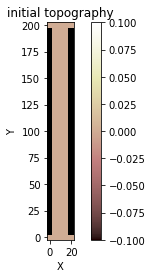

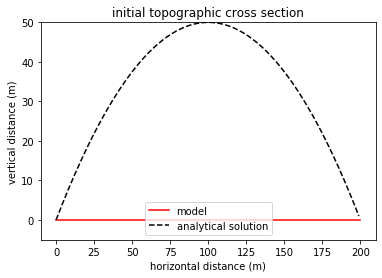

In [6]:
# Code Block 6

figure(1)
imshow_grid(mg, 'topographic__elevation')
title('initial topography')
figure(2)
elev_rast = mg.node_vector_to_raster(
            mg.at_node['topographic__elevation'])
plot(ys_grid, elev_rast[:, 2], 'r-', label='model')
plot(ys, zs, 'k--', label='analytical solution')
ylim((-5,50)) #may want to change upper limit if D changes
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
legend(loc='lower center')
_ = title('initial topographic cross section')

Now we are ready to evolve the landscape and compare it to the steady state solution.

Below is the time loop that does all the calculations. 

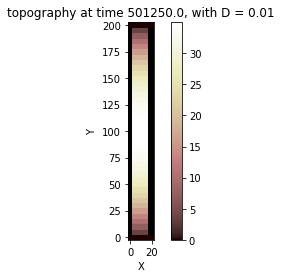

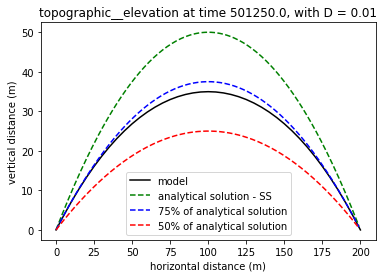

In [7]:
# Code Block 7

for i in range(nt):
    mg['node']['topographic__elevation'][mg.core_nodes] += uplift_per_step
    lin_diffuse.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first two lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        imshow_grid(mg, 'topographic__elevation')
        title('topography at time %s, with D = %s'%(time_counter,D))
        
        figure(2)
        elev_rast = mg.node_vector_to_raster(
            mg.at_node['topographic__elevation']
        )
        plot(ys_grid, elev_rast[:, 2], 'k-', label='model')
        plot(ys, zs, 'g--', label='analytical solution - SS')
        plot(ys, zs*0.75, 'b--', label='75% of analytical solution')
        plot(ys, zs*0.5, 'r--', label='50% of analytical solution')
        xlabel('horizontal distance (m)')
        ylabel('vertical distance (m)')
        legend(loc='lower center')
        title(
            'topographic__elevation at time %s, with D = %s'
            %(time_counter,D)
        )

Now we plot the final cross-section.

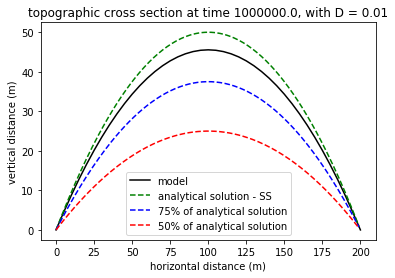

In [8]:
# Code Block 8

elev_rast = mg.node_vector_to_raster(mg.at_node['topographic__elevation'])

plot(ys_grid, elev_rast[:, 2], 'k-', label='model')
plot(ys, zs, 'g--', label='analytical solution - SS')
plot(ys, zs * 0.75, 'b--', label='75% of analytical solution')
plot(ys, zs * 0.5, 'r--', label='50% of analytical solution')
xlabel('horizontal distance (m)')
ylabel('vertical distance (m)')
legend(loc='lower center')
_ = title('topographic cross section at time %s, with D = %s'%(time_counter,D))

Now we plot the steepest slope in the downward direction across the landscape.

(To calculate the steepest slope at a location, we need to route flow across the landscape.)

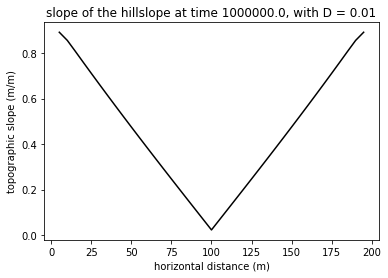

In [9]:
# Code Block 9

fr = FlowAccumulator(mg, flow_director='FlowDirectorD8') # intializing flow routing
fr.run_one_step()

plot(
    mg.node_y[mg.core_nodes],
    mg.at_node['topographic__steepest_slope'][mg.core_nodes],
    'k-'
)
xlabel('horizontal distance (m)')
ylabel('topographic slope (m/m)')
_ = title('slope of the hillslope at time %s, with D = %s'%(time_counter,D))

Has the landscape reached steady state yet? How do you know?







Answer: Not quite, but it is getting close. Go back and rerun Code Blocks 7, 8 and 9 (time loop and plotting). (Remember you can rerun a cell with shift-return, or from the cell pull-down menu.) Has it reached steady state yet?  

**What to do and hand in:**
1. In the example illustrated here ($D$ = 0.01 m$^2$yr$^{-1}$ and $U$ = 0.0001 m yr$^{-1}$). Restart everything, and use the model to determine how long it takes for the landscape to go from a flat to reach 50%, 75% and 100% of its steady-state morphology. Does the landscape approach steady state linearly in time? (You can run the time loop (Code Block 7) multiple times without running other code blocks again to continually evolve the landscape. You will initially want to rerun all the code blocks and change the value of **run_time** (Code Block 4). Determining the correct value of **run_time** to use will take some iteration.)
2. What do you think will happen when you increase $D$ (Code Block 3) by a factor of 10? Will the time to steady state differ? If yes, how? Will the topography be different? If yes, how and why? What does it mean physically, about processes, if $D$ increases? Answer these questions before running any code. 
3. Now set $D$ = 0.1 m$^2$yr$^{-1}$ and rerun landscape evolution from an initial flat. Illustrate the final steady state topography and record the time to steady state. Discuss how the landscape differs from the results in question 1. Discuss how the results are similar to or different from your intuition. It is OK if your intuition was wrong! 
4. What do you think will happen when you increase **uplift_rate** (Code Block 4) by a factor of 10? Will the time to steady state differ? If yes, how? Will the topography be different? If yes, how and why? Answer these questions first, and then rerun the code with **uplift_rate** = 0.001 m yr$^{-1}$. (Make sure you change $D$ - Code Block 3 - back to the original value of 0.01 m$^2$yr$^{-1}$ and restart from a flat surface.) Illustrate the final steady state topography. Discuss how these results differ from the results in question 1 and how the results match (or do not) your intuition. It is OK if your intuition was wrong.

You should hand in a typed document that answers the above questions with supporting plots. Plots should be embedded in the text, or, if they all fall at the end, they need to be clearly labeled, e.g. each plot has a figure number and plots are referred to by figure number in the text.

Other questions you can explore.

1. What happens to time to steady state as you increase the length of your hillslope? 
2. Does grid resolution affect your answers? If so, how?
